# CatBoost на практике: регрессия и классификация на реальных данных

В этом ноутбуке мы разберём библиотеку **CatBoost** на двух задачах:

- **регрессия** на датасете *California Housing*;
- **классификация** на сложном многоклассовом датасете *Covertype*.

Мы рассмотрим:

- базовое применение `CatBoostRegressor` и `CatBoostClassifier`;
- ключевые идеи CatBoost (обработка категориальных признаков, ordered boosting, oblivious trees);
- влияние важнейших гиперпараметров (глубина, количество итераций, регуляризация);
- визуализацию результатов и важностей признаков.

Бэйзлайны (линейная регрессия, RandomForest, логистическая регрессия), а также XGBoost и LightGBM уже разобраны в отдельных ноутбуках, поэтому здесь мы фокусируемся именно на **CatBoost**.

## 1. Импорт библиотек и подготовка данных

Используем те же датасеты, что и в ноутбуках про XGBoost и LightGBM:

- `fetch_california_housing` — задача регрессии (цены на жильё в Калифорнии);
- `fetch_covtype` — задача многоклассовой классификации типов лесного покрова.

CatBoost умеет нативно работать с категориальными признаками, но в этих датасетах все признаки уже числовые, поэтому мы не будем отдельно задавать `cat_features`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

from catboost import CatBoostRegressor, CatBoostClassifier, Pool

# Настройки отображения
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42

### 1.1. Датасет для регрессии: California Housing

Датасет содержит информацию о районах в Калифорнии и среднюю стоимость жилья в каждом районе.

Целевая переменная: `MedHouseVal` — средняя стоимость дома (в сотнях тысяч долларов).

In [2]:
california = fetch_california_housing(as_frame=True)
X_reg = california.data
y_reg = california.target

print('Shape:', X_reg.shape)
X_reg.head()

Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


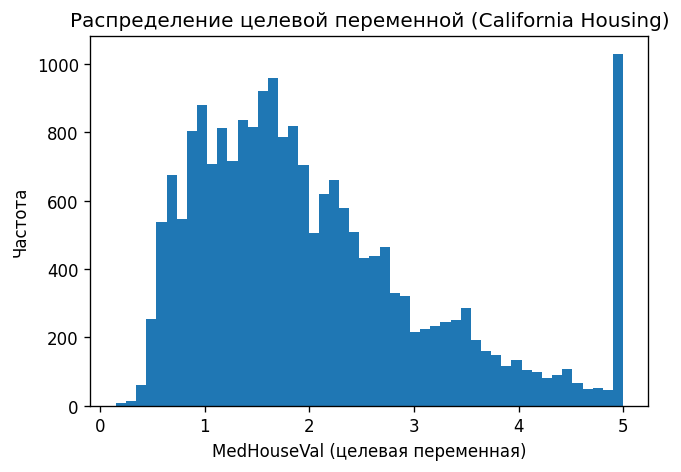

In [3]:
plt.hist(y_reg, bins=50)
plt.xlabel('MedHouseVal (целевая переменная)')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной (California Housing)')
plt.show()

In [4]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)
X_reg_train.shape, X_reg_test.shape

((16512, 8), (4128, 8))

### 1.2. Датасет для классификации: Covertype

Датасет **Covertype** содержит данные о типе лесного покрова в разных участках территории США.

- Целевая переменная — тип лесного покрова (7 классов);
- Признаки — высота, уклон, расстояние до водоёмов/дорог, почвенные характеристики и т.д.

Возьмём случайную подвыборку для ускорения вычислений.

In [5]:
covtype = fetch_covtype(as_frame=True)
X_clf_full = covtype.data
y_clf_full = covtype.target

print('Полный датасет Covertype:', X_clf_full.shape)

# Подвыборка, например 50000 объектов
n_samples = 50000
rng = np.random.RandomState(RANDOM_STATE)
indices = rng.choice(len(X_clf_full), size=n_samples, replace=False)

X_clf = X_clf_full.iloc[indices].reset_index(drop=True)
y_clf = y_clf_full.iloc[indices].reset_index(drop=True)

X_clf.shape, y_clf.value_counts().sort_index()

Полный датасет Covertype: (581012, 54)


((50000, 54),
 Cover_Type
 1    18401
 2    24299
 3     3082
 4      222
 5      796
 6     1463
 7     1737
 Name: count, dtype: int64)

In [18]:
X_clf.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,3351.0,206.0,27.0,726.0,124.0,3813.0,192.0,252.0,180.0,2271.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2732.0,129.0,7.0,212.0,1.0,1082.0,231.0,236.0,137.0,912.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2572.0,24.0,9.0,201.0,25.0,957.0,216.0,222.0,142.0,2191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2824.0,69.0,13.0,417.0,39.0,3223.0,233.0,214.0,110.0,6478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2529.0,84.0,5.0,120.0,9.0,1092.0,227.0,231.0,139.0,4983.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)
X_clf_train.shape, X_clf_test.shape

((40000, 54), (10000, 54))

## 2. CatBoost: основные идеи и особенности

CatBoost ("Categorical Boosting") — градиентный бустинг по деревьям, специально разработанный для работы с табличными данными и **категориальными признаками**. Основные идеи:

### 2.1. Обработка категориальных признаков

Ключевая фича CatBoost: CatBoost изначально спроектирован для табличных данных с большим количеством **категориальных признаков** и умеет работать с ними нативно — без явного One-Hot Encoding.

- для категориальных колонок CatBoost строит **таргет-статистики** (target statistics) вида:
  
  $$
  \text{TS}(x) = \frac{\sum_{i: x_i = x} y_i + a \cdot P}{\#\{i: x_i = x\} + a},
  $$
  
  где $P$ — глобальное среднее по таргету, а $a$ — параметр сглаживания;
- для комбинаций категорий (feature combinations) вычисляются аналогичные статистики.

**Проблема простой target encoding** — утечка таргета (target leakage): мы используем $y_i$ для построения признака для того же объекта $i$.


Основные варианты использования:

1. **Явно указать категориальные признаки.**
   - Можно передать список индексов или имён колонок в `cat_features`:
     ```python
     from catboost import Pool, CatBoostRegressor

     cat_cols = ['brand', 'cpu_model', 'city']
     train_pool = Pool(
         X_train, y_train,
         cat_features=cat_cols
     )

     model = CatBoostRegressor(...)

     model.fit(train_pool, eval_set=...)
     ```
   - То же можно сделать, передавая `cat_features` напрямую в `fit`:
     ```python
     model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_val, y_val))
     ```

2. **Использовать тип столбца `category`/`str` в `pandas`.**
   - Если колонки имеют тип `object` / `str` / `category`, CatBoost автоматически считает их категориальными:
     ```python
     X['brand'] = X['brand'].astype('category')
     X['cpu_model'] = X['cpu_model'].astype('category')
     ```
   - При этом можно (и рекомендуется) всё равно передавать `cat_features`, чтобы явно задокументировать, какие признаки считаются категориальными.

Внутри CatBoost строит для категориальных признаков специальные **таргет-статистики** и использует **ordered boosting**, чтобы избежать утечки таргета при вычислении этих статистик.

В этом ноутбуке мы работаем с датасетами, где все признаки уже представлены числовыми колонками (в том числе «категориальная» информация может быть закодирована бинарными признаками). Поэтому мы не передаём `cat_features` и используем CatBoost как числовой бустинг.  
В реальных задачах с настоящими категориальными колонками (строки / категориальные коды) рекомендуется **не делать One-Hot заранее**, а использовать нативную поддержку категорий в CatBoost через `cat_features`.


### 2.2. Ordered boosting и "ordered" target statistics

CatBoost решает проблему утечки таргета с помощью **ordered boosting**:

- объекты в обучении случайно переупорядочиваются;
- для объекта с индексом $t$ таргет-статистика рассчитывается только по объектам с индексами $< t$;
- для бустинга деревья на шаге $m$ обучаются тоже в "упорядоченной" схеме.

Интуитивно это имитирует **онлайн-обучение во времени**: для текущего объекта мы используем только прошлое, но не будущее.

**Зачем это нужно?**

- резко снижает смещение оценок на категориальных признаках;
- уменьшает переобучение на категориальных фичах;
- даёт более устойчивое качество без тонкой ручной настройки encoding-а.

### 2.3. Oblivious trees (симметричные деревья)

CatBoost строит так называемые **oblivious trees** — симметричные деревья:

- на каждом уровне используется один и тот же признак и порог;
- дерево глубины $d$ содержит $2^d$ листьев;
- путь от корня до листа соответствует бинарной маске длины $d$ (на каждом уровне: "лево/право").

**Зачем это нужно?**

- сильно упрощает структуру деревьев;
- позволяет очень эффективно реализовать применение модели (быстрый инференс);
- даёт более регулярную модель, которая часто лучше обобщает данные.

### 2.4. Основные гиперпараметры CatBoost

- `depth` — глубина дерева (обычно от 4 до 10);
- `iterations` — число деревьев (итераций бустинга);
- `learning_rate` — шаг бустинга;
- `l2_leaf_reg` — L2-регуляризация весов листьев;
- `random_strength` — степень случайности при выборе сплитов;
- `border_count` — число бинов для числовых признаков (гистограммный алгоритм).

### 2.5. Преимущества CatBoost на практике

- очень удобная работа с категориальными и смешанными табличными данными "из коробки";
- хорошее качество при минимальной предобработке признаков;
- устойчивость к переобучению за счёт ordered boosting и встроенной регуляризации;
- конкурентоспособность по качеству с XGBoost/LightGBM на табличных задачах.

## 3. Регрессия с CatBoostRegressor

Начнём с задачи регрессии на California Housing.

### 3.1. Базовая модель CatBoostRegressor

Соберём базовую модель с умеренными значениями параметров.

Обратите внимание:

- мы используем `loss_function='RMSE'`;
- `depth=6` и `iterations=400` — типичные стартовые значения;
- `verbose` поставим равным `100`, чтобы видеть прогресс, но не засорять вывод.

In [7]:
reg_train_pool = Pool(X_reg_train, y_reg_train)
reg_test_pool = Pool(X_reg_test, y_reg_test)

cat_reg_base = CatBoostRegressor(
    loss_function='RMSE',
    depth=6,
    iterations=600,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    random_state=RANDOM_STATE,
    verbose=100
)

cat_reg_base.fit(reg_train_pool)
y_pred_cat_reg = cat_reg_base.predict(reg_test_pool)

mae_cat = mean_absolute_error(y_reg_test, y_pred_cat_reg)
rmse_cat = np.sqrt(mean_squared_error(y_reg_test, y_pred_cat_reg))
r2_cat = r2_score(y_reg_test, y_pred_cat_reg)

print(f'CatBoostRegressor MAE:  {mae_cat:.4f}')
print(f'CatBoostRegressor RMSE: {rmse_cat:.4f}')
print(f'CatBoostRegressor R2:   {r2_cat:.4f}')

0:	learn: 1.1244518	total: 158ms	remaining: 1m 2s
100:	learn: 0.5369823	total: 563ms	remaining: 1.67s
200:	learn: 0.4900335	total: 981ms	remaining: 971ms
300:	learn: 0.4556483	total: 1.39s	remaining: 457ms
399:	learn: 0.4339297	total: 1.83s	remaining: 0us
CatBoostRegressor MAE:  0.3224
CatBoostRegressor RMSE: 0.4801
CatBoostRegressor R2:   0.8241


### 3.2. Визуализация предсказаний

Построим график "истинные vs предсказанные" значения для CatBoostRegressor.

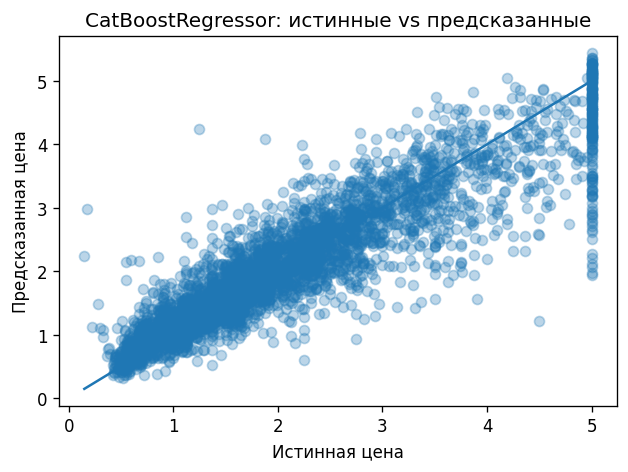

In [8]:
plt.figure()
plt.scatter(y_reg_test, y_pred_cat_reg, alpha=0.3)
plt.xlabel('Истинная цена')
plt.ylabel('Предсказанная цена')
plt.title('CatBoostRegressor: истинные vs предсказанные')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()])
plt.show()

## 4. Регрессия: влияние гиперпараметров CatBoost

Начнём с параметра `depth` — глубины oblivious-деревьев.

### 4.1. Эксперимент: `depth`

Изменяем `depth` и смотрим на MAE, RMSE и $R^2$.

В цикле отключим вывод (`verbose=False`), чтобы не засорять ноутбук.

In [9]:
depths = [4, 6, 8, 10]
results_depth = []

for d in depths:
    model = CatBoostRegressor(
        loss_function='RMSE',
        depth=d,
        iterations=300,
        learning_rate=0.05,
        l2_leaf_reg=3.0,
        random_state=RANDOM_STATE,
        verbose=False
    )
    model.fit(reg_train_pool)
    preds = model.predict(reg_test_pool)
    mae = mean_absolute_error(y_reg_test, preds)
    rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
    r2 = r2_score(y_reg_test, preds)
    results_depth.append((d, mae, rmse, r2))

df_depth = pd.DataFrame(results_depth, columns=['depth', 'MAE', 'RMSE', 'R2'])
df_depth

,depth,MAE,RMSE,R2
0,4,0.355509,0.522984,0.791277
1,6,0.332202,0.492914,0.814589
2,8,0.319099,0.476490,0.826739
3,10,0.311237,0.467696,0.833076


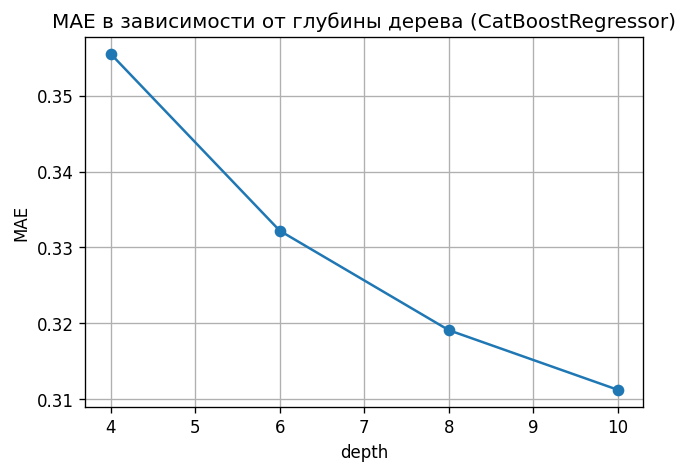

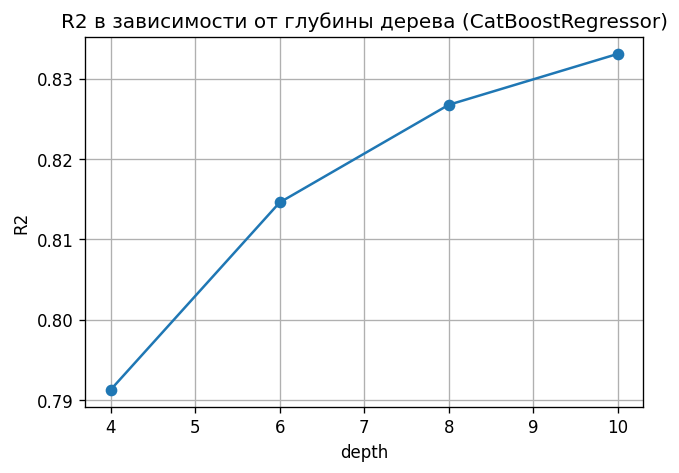

In [10]:
plt.figure()
plt.plot(df_depth['depth'], df_depth['MAE'], marker='o')
plt.xlabel('depth')
plt.ylabel('MAE')
plt.title('MAE в зависимости от глубины дерева (CatBoostRegressor)')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_depth['depth'], df_depth['R2'], marker='o')
plt.xlabel('depth')
plt.ylabel('R2')
plt.title('R2 в зависимости от глубины дерева (CatBoostRegressor)')
plt.grid(True)
plt.show()

### 4.2. Эксперимент: `l2_leaf_reg`

Параметр `l2_leaf_reg` отвечает за L2-регуляризацию весов листьев.

Посмотрим, как его изменение влияет на качество.

In [11]:
l2_values = [1.0, 3.0, 10.0, 30.0]
results_l2 = []

for l2 in l2_values:
    model = CatBoostRegressor(
        loss_function='RMSE',
        depth=6,
        iterations=300,
        learning_rate=0.05,
        l2_leaf_reg=l2,
        random_state=RANDOM_STATE,
        verbose=False
    )
    model.fit(reg_train_pool)
    preds = model.predict(reg_test_pool)
    mae = mean_absolute_error(y_reg_test, preds)
    rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
    r2 = r2_score(y_reg_test, preds)
    results_l2.append((l2, mae, rmse, r2))

df_l2 = pd.DataFrame(results_l2, columns=['l2_leaf_reg', 'MAE', 'RMSE', 'R2'])
df_l2

,l2_leaf_reg,MAE,RMSE,R2
0,1.0,0.330995,0.491235,0.815850
1,3.0,0.332202,0.492914,0.814589
2,10.0,0.334098,0.496471,0.811904
3,30.0,0.339399,0.506169,0.804483


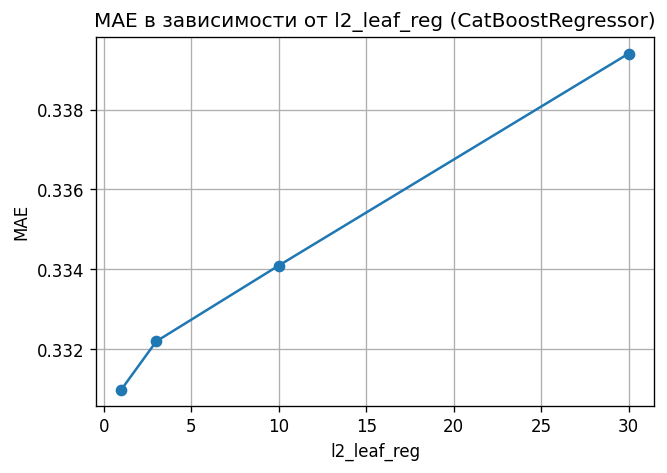

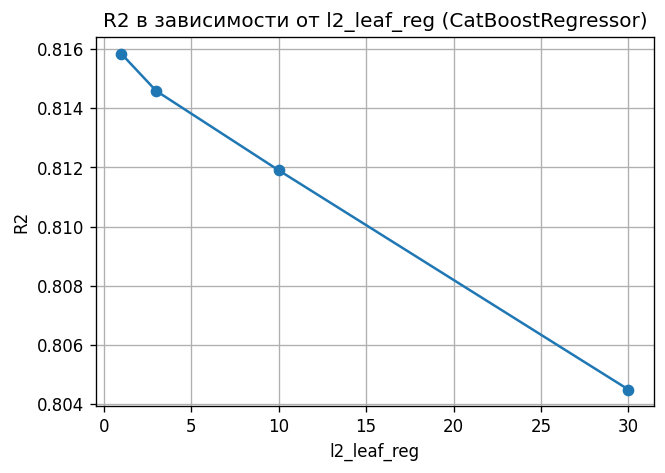

In [12]:
plt.figure()
plt.plot(df_l2['l2_leaf_reg'], df_l2['MAE'], marker='o')
plt.xlabel('l2_leaf_reg')
plt.ylabel('MAE')
plt.title('MAE в зависимости от l2_leaf_reg (CatBoostRegressor)')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_l2['l2_leaf_reg'], df_l2['R2'], marker='o')
plt.xlabel('l2_leaf_reg')
plt.ylabel('R2')
plt.title('R2 в зависимости от l2_leaf_reg (CatBoostRegressor)')
plt.grid(True)
plt.show()

## 5. Регрессия: важности признаков

Посмотрим, какие признаки наиболее важны для CatBoostRegressor на California Housing.

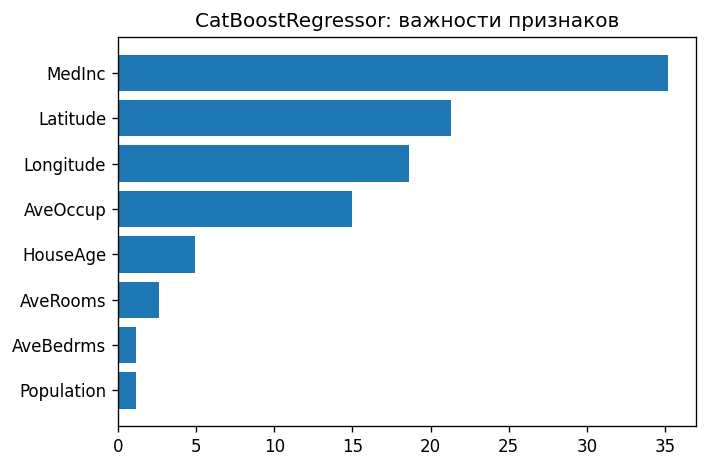

In [13]:
importances_reg = cat_reg_base.get_feature_importance(reg_train_pool)
feature_names_reg = X_reg.columns

order = np.argsort(importances_reg)

plt.figure(figsize=(6, 4))
plt.barh(range(len(importances_reg)), importances_reg[order])
plt.yticks(range(len(importances_reg)), feature_names_reg[order])
plt.title('CatBoostRegressor: важности признаков')
plt.tight_layout()
plt.show()

## 6. Классификация с CatBoostClassifier (многоклассовая задача)

Теперь применим CatBoost к многоклассовой задаче Covertype.

### 6.1. Базовая модель CatBoostClassifier

Соберём базовую модель CatBoostClassifier. Для многоклассовой задачи используем `loss_function='MultiClass'`.

In [17]:
clf_train_pool = Pool(X_clf_train, y_clf_train)
clf_test_pool = Pool(X_clf_test, y_clf_test)

cat_clf_base = CatBoostClassifier(
    loss_function='MultiClass',
    depth=8,
    iterations=600,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    verbose=100
)

cat_clf_base.fit(clf_train_pool)
y_pred_cat_clf = cat_clf_base.predict(clf_test_pool)
y_pred_cat_clf = y_pred_cat_clf.ravel().astype(int)

acc_cat = accuracy_score(y_clf_test, y_pred_cat_clf)
f1_cat = f1_score(y_clf_test, y_pred_cat_clf, average='macro')

print(f'CatBoostClassifier accuracy: {acc_cat:.4f}')
print(f'CatBoostClassifier macro-F1: {f1_cat:.4f}')

0:	learn: 1.6818196	total: 88.9ms	remaining: 53.3s
100:	learn: 0.4934940	total: 20.6s	remaining: 1m 41s
200:	learn: 0.4054766	total: 42.7s	remaining: 1m 24s
300:	learn: 0.3520634	total: 59.8s	remaining: 59.4s
400:	learn: 0.3154540	total: 1m 17s	remaining: 38.3s
500:	learn: 0.2862380	total: 1m 26s	remaining: 17.1s
599:	learn: 0.2613871	total: 1m 35s	remaining: 0us
CatBoostClassifier accuracy: 0.8626
CatBoostClassifier macro-F1: 0.7867


### 6.2. Матрица ошибок

Построим матрицу ошибок для CatBoostClassifier, чтобы понять, какие классы чаще путаются между собой.

In [15]:
cm = confusion_matrix(y_clf_test, y_pred_cat_clf)
cm

array([[3037,  601,    0,    0,    2,    0,   40],
       [ 455, 4350,   36,    0,    6,   13,    0],
       [   0,   36,  555,    0,    0,   26,    0],
       [   0,    0,   15,   26,    0,    3,    0],
       [   2,   91,    3,    0,   63,    0,    0],
       [   1,   35,   78,    4,    0,  175,    0],
       [  62,    7,    0,    0,    0,    0,  278]])

### 6.3. Классификация: влияние `depth`

Посмотрим, как глубина деревьев влияет на качество классификации (accuracy и macro-F1).

In [20]:
depths_clf = [4, 6, 8, 10]
results_clf_depth = []

for d in depths_clf:
    print(f"Depth: {d}")
    model = CatBoostClassifier(
        loss_function='MultiClass',
        depth=d,
        iterations=300,
        learning_rate=0.1,
        l2_leaf_reg=3.0,
        random_state=RANDOM_STATE,
        verbose=False
    )
    model.fit(clf_train_pool)
    pred = model.predict(clf_test_pool).ravel().astype(int)
    acc = accuracy_score(y_clf_test, pred)
    f1 = f1_score(y_clf_test, pred, average='macro')
    results_clf_depth.append((d, acc, f1))

df_clf_depth = pd.DataFrame(results_clf_depth, columns=['depth', 'accuracy', 'macro_F1'])
df_clf_depth

Depth: 4
Depth: 6
Depth: 8
Depth: 10


,depth,accuracy,macro_F1
0,4,0.7727,0.626222
1,6,0.8098,0.689452
2,8,0.8372,0.734623
3,10,0.8583,0.776801


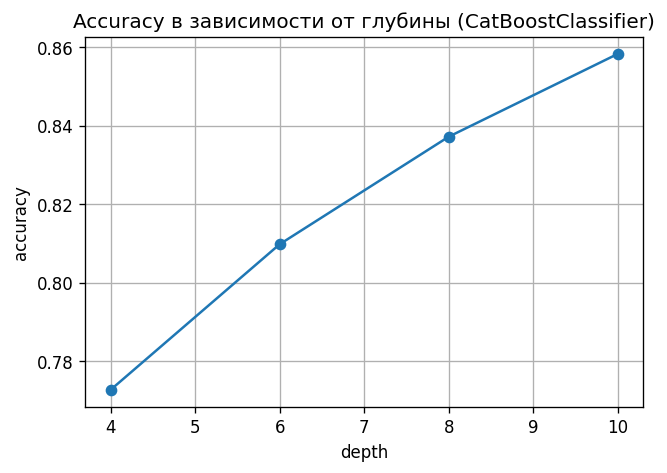

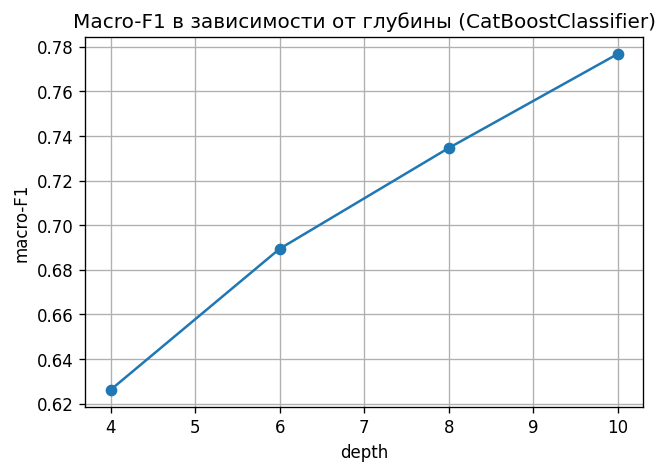

In [21]:
plt.figure()
plt.plot(df_clf_depth['depth'], df_clf_depth['accuracy'], marker='o')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('Accuracy в зависимости от глубины (CatBoostClassifier)')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_clf_depth['depth'], df_clf_depth['macro_F1'], marker='o')
plt.xlabel('depth')
plt.ylabel('macro-F1')
plt.title('Macro-F1 в зависимости от глубины (CatBoostClassifier)')
plt.grid(True)
plt.show()

### 6.4. Важности признаков (классификация)

Посмотрим, какие признаки оказывают наибольшее влияние на решение CatBoostClassifier на Covertype.

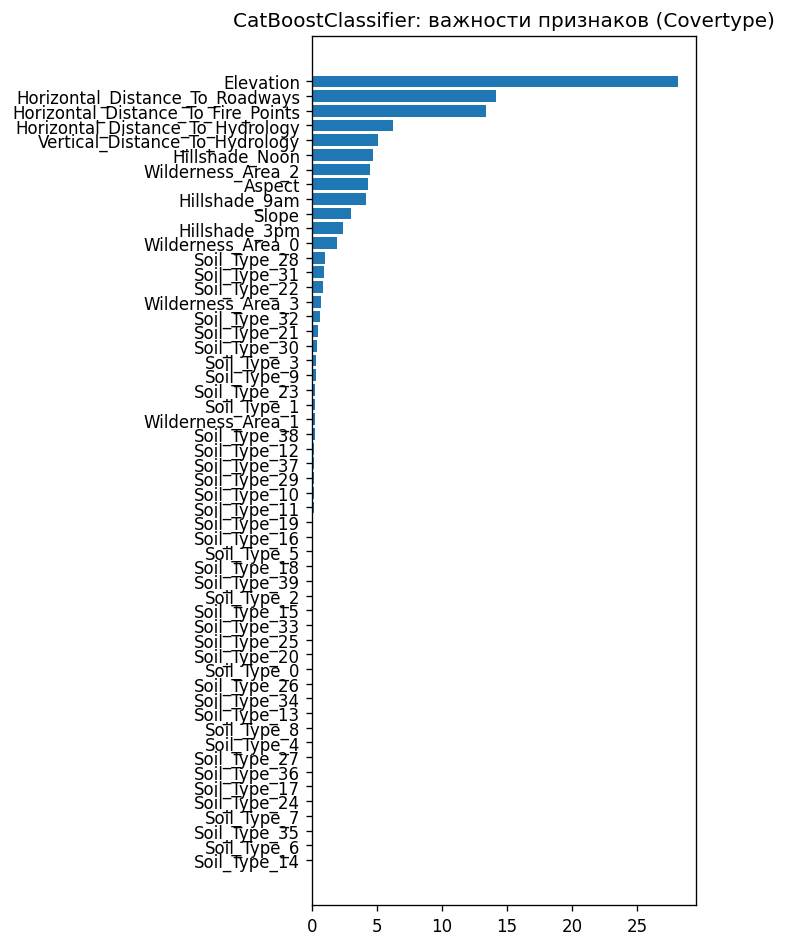

In [22]:
importances_clf = cat_clf_base.get_feature_importance(clf_train_pool)
feature_names_clf = X_clf.columns

order_clf = np.argsort(importances_clf)

plt.figure(figsize=(6, 8))
plt.barh(range(len(importances_clf)), importances_clf[order_clf])
plt.yticks(range(len(importances_clf)), feature_names_clf[order_clf])
plt.title('CatBoostClassifier: важности признаков (Covertype)')
plt.tight_layout()
plt.show()

## 7. Выводы

В этом ноутбуке мы:

- применили **CatBoostRegressor** к задаче регрессии California Housing и изучили влияние глубины деревьев и L2-регуляризации на качество;
- проанализировали важности признаков для регрессии;
- применили **CatBoostClassifier** к многоклассовой задаче Covertype и оценили качество по accuracy и macro-F1;
- посмотрели, как глубина деревьев влияет на качество многоклассовой классификации и какие признаки наиболее важны.

Основные практические выводы:

- CatBoost — мощный алгоритм градиентного бустинга, особенно удобный для табличных данных с категориальными признаками;
- ordered boosting и oblivious trees дают устойчивое качество и быструю инференс-модель;
- глубина деревьев (`depth`) и регуляризация (`l2_leaf_reg`) являются ключевыми рычагами контроля сложности модели;
- анализ важностей признаков помогает интерпретировать поведение модели и лучше понять структуру данных.

Теперь у нас есть три подробных ноутбука по XGBoost, LightGBM и CatBoost, которые можно использовать как основу для сравнения этих алгоритмов на одних и тех же задачах.